<a href="https://colab.research.google.com/github/sh-r/3-1_DOP/blob/master/DOP_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below code referenced from:

*   https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

*   https://colab.research.google.com/drive/1Mh2HP_Mfxoao6qNFbhfV3u28tG8jAVGk#scrollTo=45en565PPLce

In [1]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [2]:
#check if the nvidia gpu is available for training
!nvidia-smi

Sat Dec  4 03:33:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Cloning darknet

In [3]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15376, done.
remote: Total 15376 (delta 0), reused 0 (delta 0), pack-reused 15376
Receiving objects: 100% (15376/15376), 14.01 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (10340/10340), done.


In [4]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [5]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [6]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

Downloading the pretrained weights that were used for MS COCO dataset

In [7]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-12-04 03:34:51--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  61.5MB/s    in 4.1s    

2021-12-04 03:34:55 (57.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Functions for later

In [8]:
# define helper functions

# plotting the loss plot
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

Mounting drive

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 1_Numpy_Assignment.ipynb
'2019A3PS1237H_1 (1).asc'
'2019A3PS1237H_1 (2).asc'
'2019A3PS1237H (1).asc'
 2019A3PS1237H_1.asc
'2019A3PS1237H (1).pdf'
'2019A3PS1237H (1).rar'
'2019A3PS1237H (1).zip'
'2019A3PS1237H (2).asc'
 2019A3PS1237H_2.asc
'2019A3PS1237H (2).rar'
'2019A3PS1237H (3).pdf'
 2019A3PS1237H.asc
 2019A3PS1237H_assignment2_1a.png
 2019A3PS1237H_assignment2_2.png
 2019A3PS1237H_assignment2_3.png
 2019A3PS1237H_assignment2_4.png
 2019A3PS1237H_assignment2_5.png
 2019A3PS1237H_assignment2_6.png
 2019A3PS1237H_assignment2_7.png
 2019A3PS1237H_cascode_nmos.asc
 2019A3PS1237H_CB.asc
 2019A3PS1237H_CB.zip
 2019A3PS1237H_CC.asc
 2019A3PS1237H_CC.zip
 2019A3PS1237H-Centre_Tapped_Full_Wave_Rectifier.asc
'2019A3PS1237H-Clipper_&_Peak_Detector.asc'
'2019A3PS1237H- D flipflop.asc'
 2019A3PS1237H-Filter.asc
 2019A3PS1237H-Full_Wave_Bridge_Rectifier.asc
 2019A3PS1237H.gdoc
'2019A3PS1237H- JK flipflop.asc'
 2019A3PS1237H_Lab10.pdf
 2019A3PS1237H_Lab2.pdf
 2019A3PS12

In [10]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/DOP/yolov3

backup		  generate_train.py  obj.names	yolov3_custom.cfg
generate_test.py  obj.data	     obj.zip


In [11]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/DOP/yolov3/obj.zip ../

In [12]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/obj/nh03562.jpg    
  inflating: data/obj/nh03562.txt    
  inflating: data/obj/nh03563.jpg    
  inflating: data/obj/nh03563.txt    
  inflating: data/obj/nh03564.jpg    
  inflating: data/obj/nh03564.txt    
  inflating: data/obj/nh03565.jpg    
  inflating: data/obj/nh03565.txt    
  inflating: data/obj/nh03566.jpg    
  inflating: data/obj/nh03566.txt    
  inflating: data/obj/nh03567.jpg    
  inflating: data/obj/nh03567.txt    
  inflating: data/obj/nh03568.jpg    
  inflating: data/obj/nh03568.txt    
  inflating: data/obj/nh03569.jpg    
  inflating: data/obj/nh03569.txt    
  inflating: data/obj/nh03570.jpg    
  inflating: data/obj/nh03570.txt    
  inflating: data/obj/nh03571.jpg    
  inflating: data/obj/nh03571.txt    
  inflating: data/obj/nh03572.jpg    
  inflating: data/obj/nh03572.txt    
  inflating: data/obj/nh03573.jpg    
  inflating: data/obj/nh03573.txt    
  inflating: data/obj/nh03574.jpg    

Configure yolov3.cfg file

In [ ]:
# download cfg to google drive and change its name
!cp cfg/yolov3.cfg /mydrive/DOP/yolov3/yolov3_custom.cfg

If your custom object detection model includes ‘n=7’ no. of classes, then:

max_batches = 2000 * n= 14000
filters = (n + 5) * 3= 36

After making the above changes in the file, upload it again

In [13]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/DOP/yolov3/yolov3_custom.cfg ./cfg

Creating 'backup' folder to save the weights

The classes names are:
*   cast
*   cryst
*   epith
*   epithn
*   leuko
*   mycete
*   eryth

Upload .names and .data files

In [14]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/DOP/yolov3/obj.names ./data
!cp /mydrive/DOP/yolov3/obj.data  ./data

Generating train.txt

In [15]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/DOP/yolov3/generate_train.py ./

In [16]:
!python generate_train.py

In [17]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


Generating test.txt

In [18]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/DOP/yolov3/generate_test.py ./

In [19]:
!python generate_test.py

In [20]:
# verify test.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     test.txt
coco.names  goal.txt	 labels			   openimages.names  train.txt
dog.jpg     horses.jpg	 obj			   person.jpg	     voc.names


Getting the pretrained weights Darknet YOLOv3 used

In [21]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2021-12-04 03:36:49--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  57.4MB/s    in 2.7s    

2021-12-04 03:36:52 (57.4 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



Start the training

In [22]:
# train your custom detector 
# dont_show flag- stops a chart from popping up since cloud can't open images on the spot
# map flag- for the values needed
#!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -map -dont_show 2>&1 > log.txt (taken as reference)

#!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -map -dont_show

#uncomment below and comment above if training stops in the middle.
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/DOP/yolov3/backup/yolov3_custom_last.weights -map -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 94934, rewritten_bbox = 0.014747 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.731343), count: 1, class_loss = 0.181707, iou_loss = 0.095542, total_loss = 0.277249 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.815945), count: 8, class_loss = 0.879928, iou_loss = 0.265857, total_loss = 1.145785 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.808362), count: 4, class_loss = 0.992535, iou_loss = 0.105037, total_loss = 1.097572 
 total_bbox = 94947, rewritten_bbox = 0.014745 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.916264), count: 1, class_loss = 0.034532, iou_loss = 0.003865, total_loss = 0.038397 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.747595), count: 6, class_loss = 1.020544, iou_loss = 0.324402, total_loss = 1.344946 
v3 (mse 

Plot

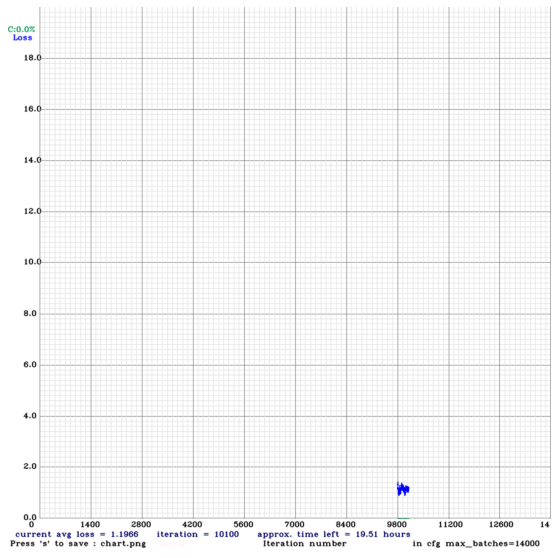

In [23]:
imShow('chart.png')

Testing and running the program

In [24]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

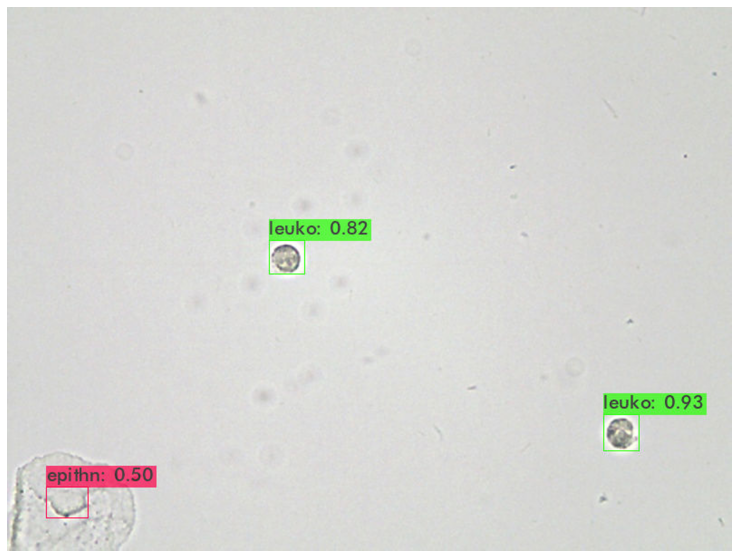

In [25]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/DOP/yolov3/backup/yolov3_custom_best.weights /mydrive/DOP/yolov3/test/nh00068.jpg -thresh 0.3
imShow('predictions.jpg')

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

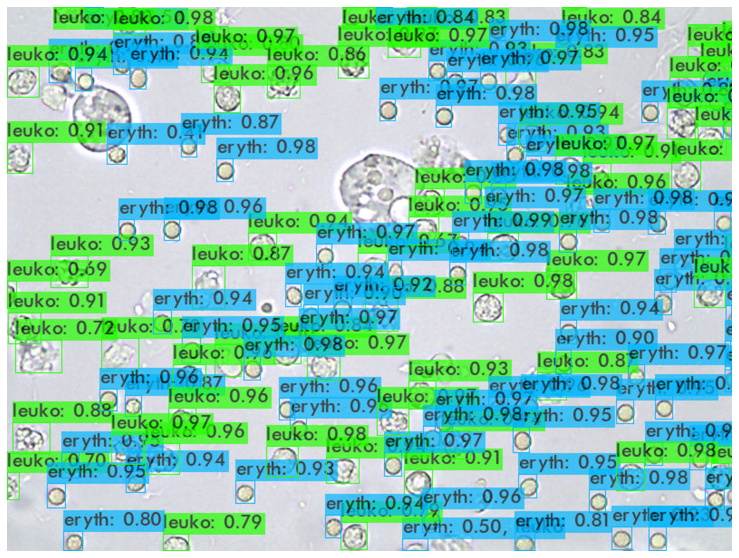

In [26]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/DOP/yolov3/backup/yolov3_custom_best.weights /mydrive/DOP/yolov3/test/nh00031.jpg -thresh 0.3
imShow('predictions.jpg')